In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import geopandas as gpd
import random
from scipy.stats import truncnorm, norm
from collections import defaultdict
import math
from shapely.ops import transform
from pyproj import Geod
import pyarrow
from datetime import datetime
import yaml

In [2]:
# Функции генерации паттернов времени и базовые функции времени созданные ранее

from data_generator.general_time import *

In [3]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [4]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\notebooks'

In [5]:
os.chdir("..")

In [6]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01'

In [7]:
# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Настройки легальных транзакций
with open("./config/legit.yaml") as f:
    legit_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

# Доп. данные для генерации транзакций

**Загрузка данных:**
- оффлайн мерчантов
- онлайн мерчантов
- девайсов клиентов и мошенников
- городов с полигонами
- городов с координатами центров
- клиентов
- фрод IP адресов
- категорий и их характеристик

In [8]:
offline_merchants = pd.read_parquet("./data/base/offline_merchants_points.parquet")
online_merchant_ids = pd.read_csv("./data/base/online_merchant_ids.csv").iloc[:, 0]
client_devices = pd.read_csv("./data/base/client_devices.csv")
fraud_devices = pd.read_csv("./data/base_fraud/fraud_devices.csv")
cities = gpd.read_file("./data/base/cities.gpkg")
city_centers = gpd.read_file("./data/base/city_centers.gpkg")
clients = pd.read_parquet("./data/clients/clients.parquet")
cat_stats_full = pd.read_csv("./data/base/cat_stats_full.csv")

### **Функция создания пустого датафрейма для транзакций**
- модуль `data_generator.utils`

In [10]:
def create_txns_df(configs):
    """
    configs: dict. Словарь с парами 'название колонки':'тип данных'
    """
    to_df = {}
    for key in configs.keys():
        data_type = configs[key]
        to_df[key] = pd.Series(dtype=data_type)

    return pd.DataFrame(to_df)

# Функции генерации времени легальных транзакций

**Датафрейм под транзакции. Этап тестов**  
Создадим пустой датафрейм под транзакции. Будем копировать и использовать его при тестах функций

In [11]:
transactions = create_txns_df(base_cfg["txns_df"])
transactions

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule


**Функция логирования для `check_min_interval_from_near_trans`**
- модуль `data_generator.legit.time.utils`

In [33]:
def log_check_min_time(client_id, txn_time, txn_unix, online, closest_txn_offline, closest_txn_online, last_txn, \
                       close_flag):
    """
    Логирует нужные данные для дебаггинга
    -------------------------------
    closest_txn_offline - pd.DataFrame. Запись о ближайшей оффлайн транзакции - может быть пустым
    closest_txn_online - pd.DataFrame. Запись о ближайшей онлайн транзакции - может быть пустым
    last_txn - pd.DataFrame. Запись о последней транзакции
    """
    if not closest_txn_offline.empty:
        closest_offline_time = closest_txn_offline.txn_time.iloc[0]
        closest_offline_unix = closest_txn_offline.unix_time.iloc[0]
    else:
        closest_offline_time = pd.NaT
        closest_offline_unix = np.nan

    if not closest_txn_online.empty:
        closest_online_time = closest_txn_online.txn_time.iloc[0]
        closest_online_unix = closest_txn_online.unix_time.iloc[0]
    else:
        closest_online_time = pd.NaT
        closest_online_unix = np.nan


    last_txn_time = last_txn.txn_time.iloc[0]
    last_txn_unix = last_txn.unix_time.iloc[0]
    last_online_flag = last_txn.online.iloc[0]
    
    log_df = pd.DataFrame({"client_id":[client_id], "txn_time":[txn_time], "txn_unix":[txn_unix], "online":[online], \
                           "closest_offline_time":[closest_offline_time], "closest_offline_unix":[closest_offline_unix], \
                            "closest_online_time":[closest_online_time], "closest_online_unix":[closest_online_unix], \
                            "last_txn_time":[last_txn_time], "last_txn_unix":[last_txn_unix], \
                           "last_online":[last_online_flag], "condition":[close_flag]})
        
    file_exists = os.path.exists("./data/generated_data/log_check_min_time.csv")
    
    if file_exists:
        log_df.to_csv("./data/generated_data/log_check_min_time.csv", mode="a", header=False)
    else:
        log_df.to_csv("./data/generated_data/log_check_min_time.csv")

## Подфункция `check_min_interval_from_near_trans` - когда есть предыдущие транзакции
- модуль `data_generator.legit.time.time`
- проверка что сгенерированное время транзакции не ближе ко времени других транзакций чем выставлено в лимитах

In [18]:
def check_min_interval_from_near_txn(client_txns, timestamp_sample, online, round_clock, configs, test=False):
    """
    Если для сгенерированного времени есть транзакции, которые по времени ближе заданного минимума, 
    то создать время на основании времени последней транзакции + установленный минимальный интервал.
    Учитывает разницу между типами транзакций: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн.
    Можно поставить свои минимальные интервалы для случаев: онлайн-онлайн, онлайн-оффлайн, оффлайн-оффлайн. 
    Для оффлайн-оффлайн - один фиксированный интервал.
    Для онлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью
    Для оффлайн-онлайн задается минимум и максимум откуда интервал берется с равной вероятностью

    Также, условия в функции сделаны так, что в параметрах функции для минимальных временных разниц
    всегда должно быть такое отношение значений:
    offline_time_diff > general_diff > online_time_diff
    то есть
    оффлайн-оффлайн разница > оффлайн-онлайн разница > онлайн-онлайн разница
    -----------------------------------------------
    client_txns: pd.DataFrame. Транзакции клиента.
    timestamp_sample: pd.DataFrame. Случайно выбранная запись из датафрейма с таймстемпами.
    online: bool. Онлайн или оффлайн категория
    round_clock: bool. Круглосуточная или дневная категория.
    configs: LegitCfg. Конфиги и данные для генерации легальных транзакций.     
    test: bool. True - логировать исполнение функции в csv
    ------------------------------------------------
    Возвращает pd.Timestamp и int unix время в секундах 
    """
    min_inter = configs.min_intervals
    offline_time_diff = min_inter["offline_time_diff"]
    online_time_diff = min_inter["online_time_diff"]
    online_ceil = min_inter["online_ceil"]
    general_diff = min_inter["general_diff"]
    general_ceil = min_inter["general_ceil"]
            
    # перевод аргументов в секунды для работы с unix time
    offline_time_diff= offline_time_diff * 60
    online_time_diff= online_time_diff * 60
    online_ceil= online_ceil * 60
    general_diff = general_diff * 60
    general_ceil = general_ceil * 60

    timestamp_unix = timestamp_sample.unix_time.iloc[0]
    # Копия, чтобы не внести изменения в исходный датафрейм
    client_txns = client_txns.copy()
    client_txns["abs_time_proximity"] = client_txns.unix_time.sub(timestamp_unix).abs()

    # Оффлайн и онлайн транзакции
    offline_txns = client_txns.loc[client_txns.online == False]
    online_txns = client_txns.loc[client_txns.online == True]
    
    # Записи о ближайших по времени оффлайн и онлайн транзакциях
    closest_txn_offline = offline_txns.loc[offline_txns.abs_time_proximity == offline_txns.abs_time_proximity.min()]
    closest_txn_online = online_txns.loc[online_txns.abs_time_proximity == online_txns.abs_time_proximity.min()]
    
    # Разница семплированного timestamp-а с ближайшей по времени оффлайн транзакцией
    # Если такая есть
    if not closest_txn_offline.empty:
        closest_offline_diff = closest_txn_offline.abs_time_proximity.iloc[0]
        
    # Если нет предыдущийх оффлайн транзакций то назначаем минимальную разницу
    # для оффлайн транзакций, чтобы дальнейшее условие closest_offline_diff < offline_time_diff не исполнилось
    else:
        closest_offline_diff = offline_time_diff

    # Разница семплированного timestamp-а с ближайшей по времени онлайн транзакцией
    # Если такая есть
    if not closest_txn_online.empty:
        closest_online_diff = closest_txn_online.abs_time_proximity.iloc[0]
        
    # Если нет предыдущийх оффлайн транзакций то назначаем минимальную разницу
    # между онлайн и оффлайн транзакциями, чтобы дальнейшее условие closest_offline_diff < general_diff 
    # либо closest_online_diff < online_time_diff не исполнилось
    else:
        closest_online_diff = general_diff
    
    # Запись о последней транзакции
    last_txn = client_txns.loc[client_txns.unix_time == client_txns.unix_time.max()]
    # Онлайн или не онлайн последняя транзакция
    last_online_flag = last_txn.online.iloc[0]
    # unix время
    last_txn_unix = last_txn.unix_time.iloc[0]

    # Отношение в контексте online флага между текущей и ближайшей транзакцией
    close_flag = set_close_flag(online=online, closest_offline_diff=closest_offline_diff, \
                                closest_online_diff=closest_online_diff, min_inter=min_inter)

    # Если нет транзакций ближе установленной разницы
    # Просто берем изначальный timestamp
    if close_flag == "No flag":
        txn_unix = timestamp_unix
        txn_time = pd.to_datetime(txn_unix, unit="s")

    # Если транзакция близка по времени к другой, то согласно типам транзакций
    # создаем другое время на основании времени и типа последней и текущей транзакции
    elif close_flag in ["offline_to_offline", "offline_to_online"]:
        # Если последняя транзакция Онлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
        if last_online_flag:
            general_random_diff = random.randint(general_diff, general_ceil)
            txn_unix = last_txn_unix + general_random_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")
            
        # Если последняя транзакция Оффлайн. То добавляем допустимую разницу между оффлайн транзакциями
        elif not last_online_flag:
            txn_unix = last_txn_unix + offline_time_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")

    # Если текущая транзакция онлайн и есть онлайн/оффлайн транзакция с разницей меньше допустимой
    elif close_flag in ["online_to_online", "online_to_offline"]:
        # Если последняя транзакция онлайн. То добавляем случайную разницу для онлайн транзакций в установленном диапазоне
        if last_online_flag:
            online_random_diff = random.randint(online_time_diff, online_ceil)
            txn_unix = last_txn_unix + online_random_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")
            
        # Если последняя транзакция Оффлайн. То добавляем случайную разницу для онлайн и оффлайн транзакций в установленном диапазоне
        elif not last_online_flag:
            general_random_diff = random.randint(general_diff, general_ceil)
            txn_unix = last_txn_unix + general_random_diff
            txn_time = pd.to_datetime(txn_unix, unit="s")

    # Проверка и корректировка времени, на случай если категория дневная, и время выходит за рамки этой категории
    # Если час меньше 8 и больше 21. Т.е. ограничение 08:00-21:59
    if not online and not round_clock and (txn_time.hour < 8 or txn_time.hour > 21):
        txn_time = txn_time + pd.Timedelta(10, unit="h")
        txn_unix = pd_timestamp_to_unix(txn_time)
        
    if not test:
        return txn_time, txn_unix
        
    # В тестовом режиме логируем некоторые данные в csv
    else:
        log_check_min_time(client_id=client_txns.client_id.iloc[0], txn_time=txn_time, txn_unix=txn_unix, online=online, \
                            closest_txn_offline=closest_txn_offline, closest_txn_online=closest_txn_online, last_txn=last_txn, \
                           close_flag=close_flag)
        return txn_time, txn_unix

**Тест функции `check_min_interval_from_near_trans`**

**Тест-кейсы**

- Текущая оффлайн, ближайшая ближе допустимого
    - ближайшая оффлайн, последняя онлайн
    - ближайшая оффлайн, последняя оффлайн
    - ближайшая онлайн, последняя оффлайн
    - ближайшая онлайн, последняя онлайн
- Текущая онлайн, ближайшая ближе допустимого
    - ближайшая оффлайн, последняя онлайн
    - ближайшая оффлайн, последняя оффлайн
    - ближайшая онлайн, последняя оффлайн
    - ближайшая онлайн, последняя онлайн
- разница допустима
    - ближайшая оффлайн
    - ближайшая онлайн

In [ ]:
# other_time = pd.to_datetime("2023-09-20 10:00:00", format="%Y-%m-%d %H:%M:%S")
# other_unix = pd_timestamp_to_unix(other_time)
# other_time, other_unix
# min_inter = legit_cfg["time"]["min_intervals"]
# set_close_flag(online=True, closest_offline_diff=60*60, closest_online_diff=5*60, min_inter=min_inter)

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np
os.chdir("..")
# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Настройки легальных транзакций
with open("./config/legit.yaml") as f:
    legit_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [2]:
from data_generator.general_time import *
from data_generator.utils import create_txns_df
from data_generator.legit.time.time import check_min_interval_from_near_txn
from data_generator.legit.time.utils import set_close_flag
from data_generator.legit.build.config import LegitConfigBuilder

builder = LegitConfigBuilder(base_cfg, legit_cfg, time_cfg)
configs = builder.build_cfg()
trans_time_test = create_txns_df(base_cfg["txns_df"]).loc[:, ['client_id', 'txn_time', 'unix_time','online','account', \
                                                                  'is_fraud', 'is_suspicious']]
print("ready for tests")

ready for tests


In [3]:
# nearest txn time

nearest_time = pd.to_datetime("2025-01-31 08:14:00", format="%Y-%m-%d %H:%M:%S")
nearest_unix = pd_timestamp_to_unix(nearest_time)
print(f"nearest: {nearest_time}, {nearest_unix}")

# last txn time

last_time = pd.to_datetime("2025-01-31 09:16:00", format="%Y-%m-%d %H:%M:%S")
last_unix = pd_timestamp_to_unix(last_time)
print(f"last: {last_time}, {last_unix}")

# current txn time

timstamp_check_min = pd.to_datetime("2025-01-31 08:19:00", format="%Y-%m-%d %H:%M:%S")
timstamp_check_min_unix = pd_timestamp_to_unix(timstamp_check_min)
timestamp_sample_check_min = pd.DataFrame([{"timestamp":timstamp_check_min, "unix_time":timstamp_check_min_unix}])
timestamp_sample_check_min

nearest: 2025-01-31 08:14:00, 1738311240
last: 2025-01-31 09:16:00, 1738314960


,timestamp,unix_time
0,2025-01-31 08:19:00,1738311540


**previous txns times and online flag**

In [4]:
# Выставить online флаги для nearest и last в соответствии с тест-кейсом. Other можно пренебречь

# trans_time_test.loc[0, ["txn_time","unix_time", "online"]] = other_time, other_unix, False
trans_time_test.loc[1, ["client_id", "txn_time","unix_time", "online"]] = 28, nearest_time, nearest_unix, True
trans_time_test.loc[2, ["client_id", "txn_time","unix_time", "online"]] = 28, last_time, last_unix, True
trans_time_test["abs_time_proximity"] = trans_time_test.unix_time.sub(trans_time_test.unix_time.shift(1)).abs() / 60
trans_time_test

,client_id,txn_time,unix_time,online,account,is_fraud,is_suspicious,abs_time_proximity
1,28.0,2025-01-31 08:14:00,1.738311e+09,True,NaN,NaN,NaN,NaN
2,28.0,2025-01-31 09:16:00,1.738315e+09,True,NaN,NaN,NaN,62.0


**Запуск функции**

In [5]:
trans_time_test.drop(columns="abs_time_proximity", inplace=True)
# Выставить в функции аргумент online в соответсвии с тест-кейсом
# True - создаваемая транзакция - онлайн. False - оффлайн
txn_time, txn_unix = check_min_interval_from_near_txn(client_txns=trans_time_test, timestamp_sample=timestamp_sample_check_min, online=True, \
                                                        round_clock=True, configs=configs, test=True)

# Запись сгенерированной транзакции в датафрейм: время, online флаг
trans_time_test.loc[3, ["client_id", "txn_time","unix_time", "online"]] = 28, txn_time, txn_unix, True
trans_time_test = trans_time_test.sort_values("txn_time")

# Расчет времени между транзакциями в минутах
trans_time_test["abs_time_proximity"] = trans_time_test.unix_time.sub(trans_time_test.unix_time.shift(1)).div(60)
trans_time_test

,client_id,txn_time,unix_time,online,account,is_fraud,is_suspicious,abs_time_proximity
1,28.0,2025-01-31 08:14:00,1.738311e+09,True,NaN,NaN,NaN,NaN
2,28.0,2025-01-31 09:16:00,1.738315e+09,True,NaN,NaN,NaN,62.00
3,28.0,2025-01-31 10:08:39,1.738318e+09,True,NaN,NaN,NaN,52.65


In [12]:
pd.read_csv("./data/test/log_check_min_time.csv")

,Unnamed: 0,client_id,txn_time,txn_unix,online,closest_offline_time,closest_offline_unix,closest_online_time,closest_online_unix,last_txn_time,last_txn_unix,last_online,condition
0,0,28.0,2025-01-31 08:19:00,1738311540,True,NaN,NaN,2025-01-31 08:14:00,1.738311e+09,2025-01-31 09:16:00,1.738315e+09,True,No flag


In [10]:
closest_online_unix = pd.read_csv("./data/test/log_check_min_time.csv").loc[0, "closest_online_unix"]
pd.to_timedelta

np.float64(1738311240.0)

# Функция `get_legit_txn_time`
- генерация времени легальных транзакций

In [64]:
def get_legit_txn_time(trans_df, time_weights, configs, round_clock, online=None):
    """
    Генерация времени для легальной транзакции
    ------------------------------------------
    trans_df: pd.DataFrame. Транзакции текущего клиента. Откуда брать информацию по предыдущим транзакциям клиента
    time_weights: pd.DataFrame. Веса часов в периоде времени
    configs: LegitCfg. Конфиги и данные для генерации легальных транзакций. 
    round_clock: bool. Круглосуточная или дневная категория.
    online: bool. Онлайн или оффлайн покупка. True or False
    -------------------------------------------
    Возвращает время для генерируемой транзакции в виде pd.Timestamp и в виде unix времени
    """
    timestamps = configs.timestamps
    timestamps_1st = configs.timestamps_1st

    # Время последней транзакции клиента. pd.Timestamp и unix в секундах
    last_txn_time = trans_df.txn_time.max()
    
    # Если нет никакой предыдущей транзакции т.е. нет последнего времени совсем
    if last_txn_time is pd.NaT:
        # время транзакции в виде timestamp и unix time.
        return sample_time_for_trans(timestamps=timestamps_1st, time_weights=time_weights)

    # Если есть предыдущая транзакция

    # берем случайный час передав веса часов для соответсвующейго временного паттерна
    txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
    # фильтруем по этому часу timestamp-ы и семплируем timestamp уже с равной вероятностью
    # Дальше будем обрабатывать этот timestamp в некоторых случаях
    timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
    timestamp_sample = timestamps_subset.sample(n=1, replace=True)

    # check_min_interval_from_near_txn проверит ближайшие к timestamp_sample по времени транзакции
    # в соответствии с установленными интервалами и если время до ближайшей транзакции меньше 
    # допустимогшо, то создаст другой timestamp. сли интервал допустимый, то вернет исходный timestamp
    txn_time, txn_unix = check_min_interval_from_near_txn(client_txns=trans_df, timestamp_sample=timestamp_sample, \
                                                          online=online, round_clock=round_clock, configs=configs)
    return txn_time, txn_unix

# **Функции для генерации остальных данных транзакции**   
- Вспомогательные и самостоятельные

## Функция генератор локации и мерчанта транзакции `get_txn_location_and_merchant`
- модуль `data_generator.legit.txndata`

In [14]:
def get_txn_location_and_merchant(online, merchants_df, category_name, client_info, configs):
    """
    Возвращает id мерчанта, геолокацию транзакции: для оффлайна это координаты и город мерчанта, для онлайна координаты по IP и город по IP.
    Возвращает IP адрес с которого совершена транзакция если это онлайн покупка.
    --------------------------------------------------------------------
    client_info: namedtuple, полученная в результате итерации через датафрейм 
             с информацией о клиентах с помощью .itertuples()
    category_name: str. Название категории покупки
    merchants_df: pd.DataFrame. Оффлайн мерчанты заранее отфильтрованные по городу клиента 
                т.к. это легальные транзакции
    online_merchant_ids: pd.Series. id для онлайн мерчантов
    configs: LegitCfg. Конфиги и данные для генерации легальных транзакций.
    """
    online_merchant_ids = configs.online_merchant_ids

    # Если онлайн покупка
    if online:
        merchant_id = online_merchant_ids.sample(n=1).iloc[0]
        # локация клиента по IP. Т.к. это не фрод. Просто записываем координаты города клиента
        trans_lat = client_info.lat
        trans_lon = client_info.lon
        # Также т.к. это не фрод, то просто берется home_ip и город из данных клиента.
        trans_ip = client_info.home_ip
        trans_city = client_info.city
        
    # Если оффлайн покупка    
    else:
        # Семплируется мерчант
        merchant = merchants_df.loc[merchants_df.category == category_name].sample(1, replace=True)
        # Берется его id, и координаты, как координаты транзакции
        merchant_id = merchant["merchant_id"].iloc[0]
        trans_lat = merchant["merchant_lat"].iloc[0]
        trans_lon = merchant["merchant_lon"].iloc[0]
        trans_ip = "not applicable"
        trans_city = merchant["city"].iloc[0]

    return merchant_id, trans_lat, trans_lon, trans_ip, trans_city

### **Тест `get_txn_location_and_merchant`**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np
import geopandas as gpd

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Настройки легальных транзакций
with open("./config/legit.yaml") as f:
    legit_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

offline_merchants = gpd.read_file("./data/cleaned_data/offline_merchants_points.gpkg")
online_merchant_ids = pd.read_csv("./data/cleaned_data/online_merchant_ids.csv").iloc[:, 0]
client_devices = pd.read_csv("./data/cleaned_data/client_devices.csv")
fraud_devices = pd.read_csv("./data/cleaned_data/fraud_devices.csv")
districts_ru = gpd.read_file("./data/cleaned_data/district_ru.gpkg")
clients_with_geo = gpd.read_file("./data/cleaned_data/clients_with_geo.gpkg") 
fraud_ips = gpd.read_file("./data/cleaned_data/fraud_ips.gpkg")
cat_stats_full = pd.read_csv("./data/cleaned_data/cat_stats_full.csv")

In [5]:
from data_generator.legit.txndata import get_txn_location_and_merchant

In [2]:
for row in clients_with_geo[clients_with_geo.client_id == 32].itertuples():
    one_client_info = row
one_client_info

Pandas(Index=31, client_id=32, district_id=52, birth_date='1980-07-28', sex='male', region='Челябинская', city='Челябинск', timezone='UTC+5', lat=55.1603659, lon=61.4007858, population=1130273, home_ip='2.60.0.32', geometry=<MULTIPOLYGON (((61.144 55.054, 61.144 55.054, 61.144 55.054, 61.144 55.054,...>)

In [3]:
offline_merchants_test_one_trans = offline_merchants[offline_merchants["city"] == one_client_info.city]
offline_merchants_test_one_trans.head(2)

,district_code,region,city,timezone,population,clients,category,avg_amt,amt_std,cat_count,merchant_id,merchant_lat,merchant_lon,geometry
88,52,Челябинская,Челябинск,UTC+5,1130273,73,gas_transport,63.577001,15.828399,56370,89.0,55.135563,61.488773,POINT (61.48877 55.13556)
89,52,Челябинская,Челябинск,UTC+5,1130273,73,grocery_pos,115.885327,51.552330,52553,90.0,55.138762,61.474582,POINT (61.47458 55.13876)


In [6]:
# Небольшой тест get_txn_location_and_merchant

get_txn_location_and_merchant(online=False, merchants_df=offline_merchants_test_one_trans, category_name="gas_transport", \
                              client_info=one_client_info, online_merchant_ids=online_merchant_ids)

(np.float64(3477.0),
 np.float64(55.17560058330962),
 np.float64(61.363321153697086),
 'not applicable',
 'Челябинск')

## Функция сбора данных транзакции в словарь `build_transaction`  
- модуль `data_generator.legit.time.utils`

In [7]:
def build_transaction(client_id, txn_time, txn_unix, amount, txn_type, channel, category_name, online, merchant_id, \
                      trans_city, trans_lat, trans_lon, trans_ip, device_id, account, is_fraud, is_suspicious, \
                      status, rule):
    """
    Собирает словарь с данными транзакции
    """

    txn_dict = {
                "client_id": client_id, "txn_time": txn_time, "unix_time":txn_unix, "amount": amount, "type": txn_type,
                "channel": channel, "category": category_name, "online": online, "merchant_id": merchant_id,
                "trans_city":trans_city, "trans_lat": trans_lat, "trans_lon": trans_lon, "trans_ip":trans_ip,
                "device_id": device_id, "account": account, "is_fraud": is_fraud, "is_suspicious":is_suspicious, "status":status,
                "rule":rule
                }

    return txn_dict

In [8]:
pos_txn_dict = {
                    "client_id": 1, "txn_time": 1, "txn_unix":1, "amount": round(4, 2), "txn_type": "purchase",
                    "channel": "POS", "category_name": 1, "online": 1, "merchant_id": 1, "device_id":78,
                    "trans_city":1, "trans_lat": 1, "trans_lon": 1,"trans_ip":"not applicable",
                    "account": np.nan, "is_fraud": False, "is_suspicious":False, "status":"approved",
                    "rule":"not applicable"
                    }

In [9]:
build_transaction(**pos_txn_dict)

{'client_id': 1,
 'txn_time': 1,
 'unix_time': 1,
 'amount': 4,
 'type': 'purchase',
 'channel': 'POS',
 'category': 1,
 'online': 1,
 'merchant_id': 1,
 'trans_city': 1,
 'trans_lat': 1,
 'trans_lon': 1,
 'trans_ip': 'not applicable',
 'device_id': 78,
 'account': nan,
 'is_fraud': False,
 'is_suspicious': False,
 'status': 'approved',
 'rule': 'not applicable'}

# Функция генератор одной легальной транзакции `generate_one_legit_txn`

In [40]:
def generate_one_legit_txn(client_info, client_trans_df, client_device_ids, category, \
                           merchants_df, configs):
    """
    Генерация одной легальной транзакции покупки для клиента.
    ------------------------------------------------
    client_info: namedtuple, полученная в результате итерации с помощью
                 .itertuples() через датафрейм с информацией о клиентах.
    client_trans_df: pd.DataFrame. Транзакции клиента.
    client_device_ids: pd.Series. id девайсов клиента.
    category: pd.DataFrame. Одна запись с категорией и её характеристиками.
    merchants_df: pd.DataFrame. Оффлайн мерчанты заранее отфильтрованные по
                  городу клиента т.к. это легальные транзакции.
    configs: LegitCfg. Конфиги и данные для генерации легальных транзакций.
    """
    all_time_weights = configs.all_time_weights

    client_id = client_info.client_id
    
    category_name = category["category"].iloc[0]
    round_clock = category["round_clock"].iloc[0]
    online = category["online"].iloc[0]
    # средняя сумма для этой категории
    amt_mean = category["avg_amt"].iloc[0]
    # стандартное отклонение сумм для этой категории
    amt_std = category["amt_std"].iloc[0]
    
    # случайно сгенерированная сумма транзакции, но не менее 1
    amount = max(1, round(np.random.normal(amt_mean, amt_std), 2))
    amount = amt_rounding(amount=amount, rate=0.6) # Случайное целочисленное округление

    # 1. Offline_24h_Legit - круглосуточные оффлайн покупки
    if not online and round_clock:
        weights_key = "Offline_24h_Legit"
        channel = "POS"
        device_id = np.nan
        
    # 2. Online_Legit - Онлайн покупки
    elif online:
        weights_key = "Online_Legit"
        # локация клиента по IP. Т.к. это не фрод. Просто записываем координаты города клиента
        channel = "ecom"
        device_id = client_device_ids.sample(n=1).iloc[0]
        
    # 3. Offline_Day_Legit - Оффлайн покупки. Дневные категории.
    elif not online and not round_clock:
        weights_key = "Offline_Day_Legit"
        channel = "POS"
        device_id = np.nan
        
    # Генерация мерчанта, координат транзакции. И если это онлайн, то IP адреса с которого сделана транзакция
    merchant_id, trans_lat, trans_lon, trans_ip, trans_city = \
                                get_txn_location_and_merchant(online=online, merchants_df=merchants_df, \
                                                              category_name=category_name, client_info=client_info, \
                                                              configs=configs)
    
    time_weights = all_time_weights[weights_key]["weights"]
    
    # Генерация времени транзакции
    txn_time, txn_unix = get_legit_txn_time(trans_df=client_trans_df, time_weights=time_weights, \
                                            configs=configs, round_clock=round_clock, online=online)
    # Статичные значения для данной функции.
    status = "approved"
    txn_type = "purchase"
    is_fraud = False
    is_suspicious = False
    account = np.nan
    rule = "not applicable"
    
    # Возвращаем словарь со всеми данными сгенерированной транзакции
    return build_transaction(client_id=client_id, txn_time=txn_time, txn_unix=txn_unix, amount=amount, txn_type=txn_type, \
                             channel=channel, category_name=category_name, online=online, merchant_id=merchant_id, \
                             trans_city=trans_city, trans_lat=trans_lat, trans_lon=trans_lon, trans_ip=trans_ip, \
                             device_id=device_id, account=account, is_fraud=is_fraud, is_suspicious=is_suspicious, \
                             status=status, rule=rule)

**Тестирование функции `generate_one_legit_txn`**

In [41]:
def get_category(cat_stats_full, random_cat=False, condition=1):
    """
    Вернет запись датафрейма с информацией об одной из 3-х категорий
    Категории выбраны под 3 временных паттерна легальных транзакций
    ---------------------------------------------------------------
    cat_stats_full - pd.DataFrame с категориями и из характеристиками
    random_cat - случайно ли выбрать из 3-х категорий. Если True - выберет с равной вероятностью.
                 Если False, то надо передать номер категории в condition
    condition - номер категории при неслучайном выборе. По умолчанию 1
                1 - Offline_24h_Legit - круглосуточные оффлайн покупки
                2 - Online_Legit - Онлайн покупки
                3 - Offline_Day_Legit - Дневные оффлайн покупки
    """
    
    if random_cat:
        condition = random.randint(1,3)
    
    # Условие 1. Offline_24h_Legit - круглосуточные оффлайн покупки
    if condition == 1:
        category = cat_stats_full.query("category == 'gas_transport'")
    
    # Условие 2. Online_Legit - Онлайн покупки
    elif condition == 2:
        category = cat_stats_full.query("category == 'shopping_net'")
    
    # Условие 3. Offline_Day_Legit - Дневные оффлайн покупки
    elif condition == 3:
        category = cat_stats_full.query("category == 'home'")


    return category

**Проверка нескольких кейсов**
1. Из предыдущих есть только **онлайн** транзакции и текущая категория это **оффлайн круглосуточная**
2. Из предыдущих есть только **онлайн** транзакции и текущая категория это **оффлайн дневная**
3. Из предыдущих есть только **оффлайн** транзакции и текущая категория это **онлайн**
4. Из предыдущих есть **оффлайн и  онлайн** транзакции и текущая категория это **оффлайн** круглосуточная
5. Из предыдущих есть **оффлайн и  онлайн** транзакции и текущая категория это **онлайн**

In [42]:
# маппинг типа распределения и аргументов для функции gen_weights_for_time

time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

In [43]:
time_weights_dict_one_trans = get_all_time_patterns(time_weight_args)

In [44]:
timestamps_one_trans_test = create_timestamps_range_df(start="2025-01-01", end="2025-02-28")

In [45]:
timestamps_one_trans_test_1st_mon = timestamps_one_trans_test.loc[timestamps_one_trans_test.timestamp.dt.month == 1]

In [46]:
for row in clients_with_geo[clients_with_geo.client_id == 33].itertuples():
    one_client_info = row
one_client_info

Pandas(Index=32, client_id=33, district_id=73, birth_date='1948-12-04', sex='female', region='Оренбургская', area='Оренбург', timezone='UTC+5', lat=51.7875191, lon=55.1017379, population=570329, home_ip='2.60.0.33', geometry=<MULTIPOLYGON (((55.019 51.79, 55.019 51.791, 55.023 51.793, 55.026 51.8, 55...>)

In [47]:
offline_merchants_test_one_trans = offline_merchants[offline_merchants["area"] == one_client_info.area]
offline_merchants_test_one_trans.head(2)

,district_code,region,area,timezone,population,clients,category,avg_amt,amt_std,cat_count,merchant_id,merchant_lat,merchant_lon,geometry
297,73,Оренбургская,Оренбург,UTC+5,570329,60,health_fitness,53.867432,47.965251,36674,298.0,51.758655,55.108108,POINT (55.10811 51.75865)
298,73,Оренбургская,Оренбург,UTC+5,570329,60,personal_care,48.233021,49.410941,39327,299.0,51.872969,55.175772,POINT (55.17577 51.87297)


In [48]:
client_device_ids_test_one = client_devices.loc[client_devices.client_id == one_client_info.client_id, "device_id"]
client_device_ids_test_one

32      58
5394    59
Name: device_id, dtype: int64

In [65]:
client_trans_df = transactions.copy()
client_trans_df

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule


In [62]:
category_test_one_trans = get_category(cat_stats_full, condition=2)
category_test_one_trans

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
5,shopping_net,834.816532,2372.197581,41779,True,0.07518,506,0.012111,True


In [58]:
one_trans_test = generate_one_legit_trans(client_info=one_client_info, client_trans_df=client_trans_df, client_device_ids=client_device_ids_test_one, \
                                          category=category_test_one_trans, merchants_df=offline_merchants_test_one_trans, \
                                 online_merchant_ids=online_merchant_ids, timestamps=timestamps_one_trans_test, \
                                     timestamps_1st_month=timestamps_one_trans_test_1st_mon, time_weights_dict=time_weights_dict_one_trans)
    
one_trans_test_df = pd.DataFrame([one_trans_test])
client_trans_df = pd.concat([client_trans_df, one_trans_test_df], ignore_index=True).sort_values("unix_time").reset_index(drop=True)
client_trans_df

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,33,2025-01-05 20:13:00,1736107980,2418.906416,purchase,ecom,shopping_net,True,6903,Оренбург,51.787519,55.101738,2.60.0.33,58,<NA>,False,False,approved,not applicable


**Проверка с рандомизацией условий**<br>
Просто прогон на большом количестве попыток, чтобы проверить будет ли падать с ошибкой

In [66]:
# 1. есть предыдущие транзакции/нет транзакций
# 2. случайная категория и, соотвественно, ее характеристики - онлайн/оффлайн, круглосуточная/дневная и т.д.

empty_vs_not = {"empty":0, "not_empty":0}

# 30 раз с нуля будем создавать 100 транзакций
for _ in range(30):
    empty_trans = random.randint(0, 1)
    client_trans_df = transactions.copy()
    
    for _ in range(100):
        
        # Условие - Пустой датафрейм перед генерацией транзакции
        if empty_trans:
            client_trans_df = transactions.copy()
            empty_vs_not["empty"] += 1
        # Если нет, просто пишем в счетчик, что условие не исполнено и датафрейм не пустой.
        else:
            empty_vs_not["not_empty"] += 1
            
        # Случайная категория
        category_test_one_trans = cat_stats_full.sample(1)
        
        one_trans_test = generate_one_legit_trans(client_info=one_client_info, client_trans_df=client_trans_df, \
                                                  client_device_ids=client_device_ids_test_one, \
                                                  category=category_test_one_trans, merchants_df=offline_merchants_test_one_trans, \
                                                 online_merchant_ids=online_merchant_ids, timestamps=timestamps_one_trans_test, \
                                     timestamps_1st_month=timestamps_one_trans_test_1st_mon, time_weights_dict=time_weights_dict_one_trans)

        one_trans_test_df = pd.DataFrame([one_trans_test])
        client_trans_df = pd.concat([client_trans_df, one_trans_test_df], ignore_index=True)

# Проверка что условие empty_trans было исполнено в обоих вариантах
(empty_vs_not["empty"], empty_vs_not["not_empty"])

(1600, 1400)

## Класс `LegitTxnsRecorder`
- Запись легальных транзакций в файл

In [ ]:
class LegitTxnsRecorder:
    """
    Запись легальных транзакций в файл.
    Предусмотрена запись частями в несколько файлов и затем
    чтение и запись в единый файл в двух копиях.
    ------------
    Атрибуты:
    ------------
    chunk_size: int. Кол-во части транз-ций для записи в файл.
    total_clients: int. Общее кол-во клиентов отобранных для генерации легальных
                   транзакций.
    category: str. Ключ к категории директорий в base.yaml.
                       Ключ это одна из папок в data/
                       Тут будут храниться сгенерированные данные.
    key_latest: str. Ключ в base.yaml для пути к файлу в директории
                data/generated/latest/. Это для записи созданных
                транз-ций как последних сгенерированных.
    key_history: str. Ключ в base.yaml для пути к директории
    data_paths: dict.
                    с историей генерации данных data/generated/history/
    prefix: str. Для названия индивидуальной папки внутри dir_category
                Например 'legit_'
    directory: str. Путь к директории в папке data/generated/history
               куда записывать чанки и собранный из них файл.
    all_txns: pd.DataFrame. Все сгенерированные транзакции. По умолчанию None.
    client_txns: list. Транз-ции текущего клиента для которого идет генерация.
    txns_chunk: list. Транз-ции текущего чанка для последующей записи в файл.
    txns_counter: int. Общее кол-во всех транзакций сгенерированных на данный
                  момент.
    clients_counter: int. Общее кол-во клиентов которые были обработаны включая
                     клиента для которого еще происходит генерация.
    chunks_counter: int. Общее кол-во чанков.
    """
    def __init__(self, configs):
        """
        configs: LegitCfg. Конфиги и данные для генерации легальных транзакций. 
        """
        self.chunk_size = configs.txn_num["chunk_size"]
        self.total_clients = configs.clients.shape[0]
        self.category = configs.dir_category
        self.key_latest = configs.key_latest
        self.key_history = configs.key_history
        self.data_paths = configs.data_paths
        self.prefix = configs.dir_prefix
        self.directory = None
        self.all_txns = None
        self.client_txns = []
        self.txns_chunk = []
        self.txns_counter = 0
        self.clients_counter = 0
        self.chunks_counter = 0


    def make_dir(self):
        """
        Создать индивидуальную директорию под текущую генерацию
        транзакций.
        """
        category = self.category
        data_paths = self.data_paths
        key_history = self.key_history
        directory = data_paths[category][key_history]
        prefix = self.prefix
        datetime_suffix = datetime.now().strftime("%Y-%m-%d_%H%M%S")
        folder_name = prefix + datetime_suffix
        path = os.path.join(directory, folder_name)

        if os.path.exists(path):
            return
        
        os.mkdir(path)
        self.directory = path


    def name_the_chunk(self):
        """
        Создать название для файла под
        запись текущего чанка.
        """
        self.chunks_counter += 1
        prefix = self.prefix
        chunks_counter = self.chunks_counter
        return f"{prefix}{chunks_counter:03d}.parquet"


    def to_chunk(self, txns_num):
        """
        txns_num: int. Кол-во созданных транз-ций текущего клиента.
        """
        chunk_size = self.chunk_size
        txns_counter = self.txns_counter
        clients_counter = self.clients_counter
        total_clients = self.total_clients
        client_txns = self.client_txns 

        # если кол-во всех транзакций кратно размеру чанка
        if txns_counter % chunk_size == 0:
            return True 
        # Условия ниже для проверки является ли транзакция последней
        # в случае если генерация закончена, но чанк меньше выставленного размера
        if clients_counter != total_clients:
            return False
        if txns_num != len(client_txns):
            return False
        # Если чанк не по размеру, но генерация транзакций закончена
        # т.е. кол-во обработанных клиентов равно общему кол-ву и
        # кол-во созданных транз. клиента равно заданному кол-ву для него
        # То возвразаем True
        return True


    def record_chunk(self, txn, txns_num):
        """
        Запись транзакций в parquet в папку где хранятся созданные транзакции
        от всех запусков генератора.
        --------
        txn: dict. Созданная транзакция.
        txns_num: int. Кол-во созданных транз-ций текущего клиента.
        """
        directory = self.directory

        self.txns_chunk.append(txn)

        # Проверка по кол-ву. Если кол-во транз-ций равно размеру чанка
        # то пишем чанк в файл
        if self.to_chunk(txns_num=txns_num):
            chunk = pd.DataFrame(self.txns_chunk)
            chunk_name = self.name_the_chunk()
            full_path = os.path.join(directory, chunk_name)

            chunk.to_parquet(full_path, engine="pyarrow")
            self.txns_chunk.clear() # сброс чанка записанного в файл


    def build_from_chunks(self):
        """
        Сборка цельного датафрейма из чанков записанных в
        файлы. Датафрейм сохраняется в атрибут all_txns.
        """
        directory = self.directory
        chunks = os.listdir(directory)

        all_chunks = []

        for file in chunks:
            path_to_chunk = os.path.join(directory, file)
            chunks_df = pd.read_parquet(path_to_chunk, engine="pyarrow")
            all_chunks.append(chunks_df)

        self.all_txns = pd.concat(all_chunks, ignore_index=True).sort_values("unix_time") \
                                .reset_index(drop=True)


    def write_built_data(self):
        """
        Запись собранного из чанков датафрейма в целый файл.
        Пишем в две директории: history/<своя_папка> и latest/ 
        """
        # Создаем полный путь для записи в папку текущей генерации
        path_history = os.path.join(self.directory, "legit_txns.parquet")
        all_txns = self.all_txns
        all_txns.to_parquet(path_history, engine="pyarrow")

        # Берем полный путь из категории "generated" и по ключу latest
        # Это путь для последних созданных легальных транзакций
        category = self.category
        key_latest = self.key_latest
        data_paths = self.data_paths
        path_latest = data_paths[category][key_latest]
        all_txns.to_parquet(path_latest, engine="pyarrow")


    def reset_counters(self):
        """
        Сброс счетчиков: txns_counter, clients_counter,
        chunks_counter
        """
        self.txns_counter = 0
        self.clients_counter = 0
        self.chunks_counter = 0

### **Тест `LegitTxnsRecorder`**

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np
os.chdir("..")
# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Настройки легальных транзакций
with open("./config/legit.yaml") as f:
    legit_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

In [3]:
from data_generator.legit.build.config import LegitConfigBuilder
from data_generator.legit.recorder import LegitTxnsRecorder
from data_generator.utils import build_transaction

chunk01 = pd.read_parquet("./data/test/legit_001.parquet")

cfg_builder = LegitConfigBuilder(base_cfg=base_cfg, legit_cfg=legit_cfg, time_cfg=time_cfg)
configs = cfg_builder.build_cfg()

txn_recorder = LegitTxnsRecorder(configs=configs)
print("ready for tests")

ready for tests


In [4]:
def reset_caches(txn_recorder):
    txn_recorder.client_txns.clear()
    txn_recorder.all_txns = None
    txn_recorder.txns_chunk = []

In [5]:
for _ in range(2):
    txn_recorder.make_dir()

**`name_the_chunk`**

In [6]:
txn_recorder.chunks_counter = 0
for _ in range(11):
    print(txn_recorder.name_the_chunk())
print(f"chunks_counter: {txn_recorder.chunks_counter}")

legit_001.parquet
legit_002.parquet
legit_003.parquet
legit_004.parquet
legit_005.parquet
legit_006.parquet
legit_007.parquet
legit_008.parquet
legit_009.parquet
legit_010.parquet
legit_011.parquet
chunks_counter: 11


**`to_chunk`**

In [7]:
txn_recorder.chunk_size

200

In [16]:
txn_recorder.reset_counters()
reset_caches(txn_recorder)

txn_recorder.directory = "./data/generated/history/legit_test"

txn_recorder.txns_counter = txn_recorder.chunk_size + 1
txn_recorder.clients_counter = 120
txn_recorder.total_clients = 120
txn_recorder.client_txns = list(range(20))
txns_num = len(txn_recorder.client_txns)
txn_recorder.to_chunk(txns_num=txns_num)

True

**`record_chunk`**

to_chunk == True
- по кратности транзакций размеру чанка

In [18]:
txn_recorder.reset_counters()
txn_recorder.directory = "./data/generated/history/legit_test"

onetxn = build_transaction(client_id=12, txn_time=2, txn_unix=3, amount=4, txn_type="aa", channel="bb", category_name="cc", online=False, merchant_id=5, \
                      trans_city="dd", trans_lat=5.6, trans_lon=6.6, trans_ip="na", device_id=0, account=0, is_fraud=False, is_suspicious=False, \
                      status="non", rule="aaavav")

chunk_txns = [build_transaction(client_id=i, txn_time=2, txn_unix=3, amount=4, txn_type="aa", channel="bb", category_name="cc", online=False, merchant_id=5, \
                      trans_city="dd", trans_lat=5.6, trans_lon=6.6, trans_ip="na", device_id=0, account=0, is_fraud=False, is_suspicious=False, \
                      status="non", rule="aaavav")
              for i in range(1,12)]

txn_recorder.txns_chunk = chunk_txns
txn_recorder.txns_counter = txn_recorder.chunk_size

txn_recorder.record_chunk(txn=onetxn, txns_num=1)

In [20]:
# pd.read_parquet("./data/generated/history/legit_test/legit_001.parquet")

In [21]:
txn_recorder.txns_chunk 

[]

to_chunk == True
- по завершению генерации транзакций

In [26]:
txn_recorder.reset_counters()
reset_caches(txn_recorder)

txn_recorder.directory = "./data/generated/history/legit_test"

onetxn = build_transaction(client_id=12, txn_time=2, txn_unix=3, amount=4, txn_type="aa", channel="bb", category_name="cc", online=False, merchant_id=5, \
                      trans_city="dd", trans_lat=5.6, trans_lon=6.6, trans_ip="na", device_id=0, account=0, is_fraud=False, is_suspicious=False, \
                      status="non", rule="aaavav")

chunk_txns = [build_transaction(client_id=i, txn_time=2, txn_unix=3, amount=4, txn_type="aa", channel="bb", category_name="cc", online=False, merchant_id=5, \
                      trans_city="dd", trans_lat=5.6, trans_lon=6.6, trans_ip="na", device_id=0, account=0, is_fraud=False, is_suspicious=False, \
                      status="non", rule="aaavav")
              for i in range(1,12)]

txn_recorder.txns_chunk = chunk_txns
txn_recorder.txns_counter = txn_recorder.chunk_size - 10
txn_recorder.clients_counter = 120
txn_recorder.total_clients = 120
txn_recorder.client_txns = chunk_txns.copy()
txn_recorder.client_txns.append(onetxn)
txns_num = len(txn_recorder.client_txns)

txn_recorder.record_chunk(txn=onetxn, txns_num=12)
os.listdir(txn_recorder.directory)

['legit_001.parquet']

In [24]:
# pd.read_parquet("./data/generated/history/legit_test/legit_001.parquet")

to_chunk == False

In [30]:
txn_recorder.reset_counters()
reset_caches(txn_recorder)

txn_recorder.directory = "./data/generated/history/legit_test"

onetxn = build_transaction(client_id=12, txn_time=2, txn_unix=3, amount=4, txn_type="aa", channel="bb", category_name="cc", online=False, merchant_id=5, \
                      trans_city="dd", trans_lat=5.6, trans_lon=6.6, trans_ip="na", device_id=0, account=0, is_fraud=False, is_suspicious=False, \
                      status="non", rule="aaavav")

chunk_txns = [build_transaction(client_id=i, txn_time=2, txn_unix=3, amount=4, txn_type="aa", channel="bb", category_name="cc", online=False, merchant_id=5, \
                      trans_city="dd", trans_lat=5.6, trans_lon=6.6, trans_ip="na", device_id=0, account=0, is_fraud=False, is_suspicious=False, \
                      status="non", rule="aaavav")
              for i in range(1,12)]

txn_recorder.txns_chunk = chunk_txns
txn_recorder.txns_counter = txn_recorder.chunk_size - 10
txn_recorder.clients_counter = 120
txn_recorder.total_clients = 120
txn_recorder.client_txns = chunk_txns.copy()
txn_recorder.client_txns.append(onetxn)
txns_num = len(txn_recorder.client_txns) + 10

txn_recorder.record_chunk(txn=onetxn, txns_num=txns_num)
os.listdir(txn_recorder.directory)

[]

**`build_from_chunks`**

In [31]:
txn_recorder.reset_counters()
reset_caches(txn_recorder)

txn_recorder.directory = "./data/generated/history/legit_test"

txn_recorder.build_from_chunks()

txn_recorder.all_txns.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account_to,is_fraud,is_suspicious,status,rule
0,2080,2025-01-01 00:16:00,1735690560,1.000000,purchase,ecom,shopping_net,True,6914.0,Хабаровск,48.464799,135.059881,2.60.7.174,3553.0,None,False,False,approved,not applicable
1,10269,2025-01-01 00:41:00,1735692060,4173.405820,purchase,ecom,misc_net,True,6967.0,Новосибирск,55.028102,82.921058,2.60.19.220,9155.0,None,False,False,approved,not applicable
2,1527,2025-01-01 00:45:00,1735692300,590.180420,purchase,POS,gas_transport,False,5809.0,Тамбов,52.740733,41.491516,not applicable,NaN,None,False,False,approved,not applicable
3,1764,2025-01-01 00:47:00,1735692420,838.754015,purchase,POS,gas_transport,False,6094.0,Воронеж,51.607044,39.275572,not applicable,NaN,None,False,False,approved,not applicable
4,3653,2025-01-01 01:03:00,1735693380,862.380067,purchase,POS,gas_transport,False,3.0,Москва,55.880307,37.538421,not applicable,NaN,None,False,False,approved,not applicable


In [32]:
txn_recorder.all_txns.shape

(59412, 19)

In [33]:
# Уникальные пары client_id, unix_time. Чтобы узнать уникальные транзакции
txn_recorder.all_txns[["client_id", "unix_time"]].value_counts().reset_index() \
            .agg({"count":"sum"})

count    59412
dtype: int64

**`write_built_data`**

In [34]:
# reset_caches(txn_recorder)

txn_recorder.directory = "./data/generated/history/legit_test"

txn_recorder.write_built_data()

In [37]:
# pd.read_parquet("./data/generated/history/legit_test/legit_txns.parquet")
# pd.read_parquet("./data/generated/latest/legit_txns.parquet")

### Функция генерации числа транзакций по нормальному распределению с ограничениями через `truncnorm`

In [71]:
def gen_trans_number_norm(avg_num, num_std, low_bound=1, up_bound=120):
    """
    Возвращает целое число по нормальному распределению.
    Число ограничено выставленными лимитами.
    ----------------------------------------
    avg_num - среднее число транзакций
    num_std - стандартное отклонение числа транзакций
    low_bound - минимальное возможное число транзакций
    up_bound - максимальное возможное число транзакций
    size - размер выборки
    """
    
    # Вернет float в виде np.ndarray
    random_float = truncnorm.rvs(a=(low_bound - avg_num) / num_std, b=(up_bound - avg_num) / num_std, \
                                 loc=avg_num, scale=num_std, size=1)

    # Преобразуем float в int и извлекаем из массива
    return random_float.astype(int)[0]

**Тест `gen_trans_number_norm`**

In [136]:
trans_num_test = []

for _ in range(1000):
    one_sample_test = gen_trans_number_norm(avg_num=50, num_std=40, low_bound=1, up_bound=120)
    trans_num_test.append(one_sample_test)
min(trans_num_test), max(trans_num_test), np.mean(trans_num_test)

(np.int64(1), np.int64(119), np.float64(53.02))

# Функция генерации нескольких легальных транзакций

In [74]:
def gen_multiple_legit_txns(configs, txn_recorder, ignore_index=True):
    """
    Генерирует несколько транзакций для каждого клиента ориентируясь 
    на существующие транзакции если они есть.
    Количество на клиента берется по нормальному распределению с 
    указанными средним и стандартным отклонением.
    Ограничение забито в функцию gen_trans_number_norm: от 1 до 120 транзакций.
    ---------------------------------------------------
    configs: LegitCfg. Конфиги и данные для генерации легальных транзакций.
    txn_recorder: LegitTxnsRecorder. 
    ignore_index: bool. Сбросить ли индекс при конкатенации датафреймов
                  в финальный датафрейм с транзакциями всех клиентов
    """
    clients_df = configs.clients
    trans_df = configs.transactions
    client_devices = configs.client_devices
    offline_merchants = configs.offline_merchants
    categories = configs.categories
    avg_txn_num = configs.txn_num["avg_txn_num"]
    txn_num_std = configs.txn_num["txn_num_std"]
    low_bound = configs.txn_num["low_bound"]
    up_bound = configs.txn_num["up_bound"]

    # Создать директорию под текущую генерацию
    txn_recorder.make_dir()
    
    # Сюда собираются все созданные датафреймы с транзакциями клиентов для объединения в конце через pd.concat
    # all_clients_trans = [trans_df]
    client_txns = txn_recorder.client_txns
    
    for client_info in clients_df.itertuples():
        txn_recorder.clients_counter += 1

        # случайное кол-во транзакций на клиента взятое из нормального распределения с мин. и макс. лимитами
        txns_num = gen_trans_number_norm(avg_num=avg_txn_num, num_std=txn_num_std, low_bound=low_bound, \
                                             up_bound=up_bound)
        merchants_from_city = offline_merchants[offline_merchants["city"] == client_info.city]
        client_transactions = trans_df.loc[trans_df.client_id == client_info.client_id]
        
        # id девайсов клиента для онлайн транзакций
        client_device_ids = client_devices.loc[client_devices.client_id == client_info.client_id, "device_id"]
        
        # Сюда будем собирать сгенрированные транзакции клиента в виде словарей.
        # client_txns = []

        for _ in range(txns_num):
            # семплирование категории для транзакции
            category = categories.sample(1, replace=True, weights=categories.share)

            # генерация одной транзакции
            one_txn = generate_one_legit_txn(client_info=client_info, client_trans_df=client_transactions, \
                                             category=category, client_device_ids=client_device_ids, \
                                             merchants_df=merchants_from_city, configs=configs)
            # pos_txns.append(one_txn)
            # Запись транз-ции в список транз-ций текущего клиента.
            client_txns.append(one_txn)
            txn_recorder.txns_counter += 1 # счетчик всех транз-ций

            # Управление записью транзакций чанками в файлы. Работает если enable=True
            txn_recorder.record_chunk(txn=one_txn, txns_num=txns_num)
            
            # Добавляем созданную транзакцию к транзакциям клиента, т.к. иногда 
            # при генерации других транзакций нужно знать уже созданные транзакции
            one_txn_df = pd.DataFrame([one_txn])
            client_transactions = pd.concat([client_transactions, one_txn_df], ignore_index=ignore_index)

        client_txns.clear() # Конец генерации на клиента. Чистим список для текущего кл-та

        # client_new_trans = pd.DataFrame(pos_txns)
        # all_clients_trans.append(client_new_trans)
        client_txns.clear() # Делаем список транз-ций клиента снова пустым

    # Сборка цельного датафрейма из чанков записанных в файлы. Датафрейм сохраняется 
    # в txn_recorder.all_txns.
    txn_recorder.build_from_chunks()
    # Запись собранного датафрейма в два файла в разные директории: data/generated/lastest/
    # И data/generated/history/<своя_папка_с_датой_временем>
    txn_recorder.write_built_data()

**Тестирование функции `gen_multiple_legit_txns`**

In [ ]:
# offline_merchants = pd.read_parquet("./data/base/offline_merchants_points.parquet")
# online_merchant_ids = pd.read_csv("./data/base/online_merchant_ids.csv").iloc[:,0]
# client_devices = pd.read_csv("./data/base/client_devices.csv")
# clients = pd.read_parquet("./data/clients/clients.parquet")

In [1]:
# Временный импорт
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir("..")

# Общие настройки
with open("./config/base.yaml") as f:
    base_cfg = yaml.safe_load(f)
# Настройки легальных транзакций
with open("./config/legit.yaml") as f:
    legit_cfg = yaml.safe_load(f)
# Настройки времени
with open("./config/time.yaml") as f:
    time_cfg = yaml.safe_load(f)

offline_merchants = pd.read_parquet("./data/base/offline_merchants_points.parquet")
online_merchant_ids = pd.read_csv("./data/base/online_merchant_ids.csv").iloc[:,0]
client_devices = pd.read_csv("./data/base/client_devices.csv")
clients = pd.read_parquet("./data/clients/clients.parquet")

In [2]:
from data_generator.legit.txns import gen_multiple_legit_txns
from data_generator.legit.build.config import LegitConfigBuilder
from data_generator.legit.recorder import LegitTxnsRecorder
from data_generator.utils import create_txns_df

cfg_builder = LegitConfigBuilder(base_cfg, legit_cfg, time_cfg)
configs = cfg_builder.build_cfg()
txn_recorder = LegitTxnsRecorder(configs=configs)

# создадим пустой датафрейм под транзакции для тестов
trans_for_test_multi = create_txns_df(base_cfg["txns_df"])
trans_for_test_multi
print("ready for tests")

ready for tests


In [3]:
%%time
gen_multiple_legit_txns(configs=configs, txn_recorder=txn_recorder, ignore_index=False)

CPU times: total: 3min 40s
Wall time: 3min 46s


In [4]:
txn_recorder.txns_counter

29529

In [5]:
multi_legit_trans_test_orig = txn_recorder.all_txns.copy()

In [6]:
# multi_legit_trans_test.to_parquet("./data/test/legit_170725_01.parquet", engine="pyarrow")

In [7]:
multi_legit_trans_test = multi_legit_trans_test_orig.sort_values("unix_time").copy() #.reset_index(drop=True)
print(multi_legit_trans_test.shape)
multi_legit_trans_test.head()

(29529, 19)


,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule
0,4118,2025-01-01 00:58:00,1735693080,3358.25,purchase,POS,grocery_pos,False,5572.0,Магнитогорск,53.374093,59.170757,not applicable,NaN,NaN,False,False,approved,not applicable
1,2777,2025-01-01 01:44:00,1735695840,800.00,purchase,ecom,misc_net,True,6787.0,Омск,54.984814,73.367464,2.60.10.66,4756.0,NaN,False,False,approved,not applicable
2,3096,2025-01-01 02:00:00,1735696800,2146.73,purchase,ecom,misc_net,True,6817.0,Санкт-Петербург,59.939125,30.315822,2.60.11.116,5313.0,NaN,False,False,approved,not applicable
3,3018,2025-01-01 03:21:00,1735701660,570.77,purchase,ecom,grocery_net,True,6818.0,Тверь,56.858540,35.911790,2.60.11.43,5179.0,NaN,False,False,approved,not applicable
4,12079,2025-01-01 03:26:00,1735701960,5134.64,purchase,ecom,shopping_net,True,6850.0,Нижний Новгород,56.324209,44.005395,2.60.20.112,9468.0,NaN,False,False,approved,not applicable


In [8]:
# Уникальные пары client_id, unix_time. Чтобы узнать уникальные транзакции
multi_legit_trans_test[["client_id", "unix_time"]].value_counts().reset_index() \
            .agg({"count":"sum"})

count    29529
dtype: int64

In [9]:
# Минимальное и максимаольное кол-во сгенерированных транзакций на клиента

multi_legit_trans_test.groupby("client_id").agg({"txn_time":"count"}).rename(columns={"txn_time":"txns_count"}).agg(["min","max"])

,txns_count
min,30
max,77


In [12]:
# pd.read_parquet(r".\data\generated\history\legit_2025-07-19_100309\legit_txns.parquet")
# pd.read_parquet(r".\data\generated\history\legit_2025-07-19_100309\legit_005.parquet")

In [13]:
clients_for_txns = configs.clients

In [14]:
# Добавим колонку со временем предыдущей транзакции каждого клиента и online статус предыдущей транзакции: True или False

for client in clients_for_txns.itertuples():
    client_id = client.client_id
    multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "prev_txn_unix"] \
                = multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "unix_time"].shift(1)
    multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "prev_online"] \
                = multi_legit_trans_test.loc[multi_legit_trans_test.client_id == client_id, "online"].shift(1)

In [15]:
# Разница между предыдущей транзакцией клиента в минутах

multi_legit_trans_test["prev_time_diff_m"] = multi_legit_trans_test.unix_time.sub(multi_legit_trans_test.prev_txn_unix).div(60)
multi_legit_trans_test.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,...,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m
0,4145,2025-01-01 02:51:00,1735699860,600.00,purchase,ecom,grocery_net,True,6974.0,Оренбург,...,2.60.15.82,7126.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN
1,2059,2025-01-01 03:03:00,1735700580,1.00,purchase,ecom,misc_net,True,6888.0,Иваново,...,2.60.7.153,3522.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN
2,1237,2025-01-01 05:20:00,1735708800,1.00,purchase,ecom,shopping_net,True,6850.0,Калуга,...,2.60.4.153,2152.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN
3,3817,2025-01-01 06:23:00,1735712580,806.83,purchase,POS,gas_transport,False,3198.0,Волжский,...,not applicable,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN
4,2388,2025-01-01 06:57:00,1735714620,600.00,purchase,POS,food_dining,False,3751.0,Астрахань,...,not applicable,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN


In [16]:
# проверим последовательность расчета разницы времени между транзакциями на паре клиентов
random_client_ids = multi_legit_trans_test.client_id.unique()[:2]
multi_legit_2_clients = multi_legit_trans_test.query("client_id in @random_client_ids")[["client_id", "txn_time", "unix_time",  \
                                                                        "prev_txn_unix", "prev_time_diff_m", "prev_online"]] \
                                        .sort_values(["client_id", "unix_time"]).groupby("client_id", as_index=False).head(5) \
                                        .fillna({"prev_txn_unix":0, "prev_time_diff_m":0}).astype({"prev_txn_unix":"int64"})
multi_legit_2_clients["prev_time_diff_m"] = pd.to_timedelta(multi_legit_2_clients["prev_time_diff_m"], unit="m")
multi_legit_2_clients

,client_id,txn_time,unix_time,prev_txn_unix,prev_time_diff_m,prev_online
1,2059,2025-01-01 03:03:00,1735700580,0,0 days 00:00:00,NaN
31,2059,2025-01-01 10:36:00,1735727760,1735700580,0 days 07:33:00,True
689,2059,2025-01-03 14:11:00,1735913460,1735727760,2 days 03:35:00,False
840,2059,2025-01-03 20:28:00,1735936080,1735913460,0 days 06:17:00,False
1043,2059,2025-01-04 17:21:00,1736011260,1735936080,0 days 20:53:00,False
0,4145,2025-01-01 02:51:00,1735699860,0,0 days 00:00:00,NaN
46,4145,2025-01-01 12:00:00,1735732800,1735699860,0 days 09:09:00,True
119,4145,2025-01-01 16:58:00,1735750680,1735732800,0 days 04:58:00,False
688,4145,2025-01-03 14:10:00,1735913400,1735750680,1 days 21:12:00,False
796,4145,2025-01-03 19:22:00,1735932120,1735913400,0 days 05:12:00,False


In [17]:
# Проверим минимальную И максимальную разницу во времени между транзакциями

multi_legit_trans_test.groupby("client_id").agg({"prev_time_diff_m":"min"}).rename(columns={"prev_time_diff_m":"min_diff"}).agg(["min","max"])

,min_diff
min,6.0
max,60.0


**Проверка минимальной разницы между оффлайн и оффлайн транзакциями**

In [18]:
test_offline_to_offline = multi_legit_trans_test.query("online == False and prev_online == False")

In [19]:
# Разница должна быть минимум 60 минут

assert test_offline_to_offline.query("prev_time_diff_m < 60").empty

**Разница между оффлайн и онлайн**

In [20]:
test_offline_to_online = multi_legit_trans_test.query("online == False and prev_online == True")

In [21]:
# Разница должна быть минимум 30 минут

assert test_offline_to_online.query("prev_time_diff_m < 30").empty

**Разница между онлайн и онлайн**

In [22]:
test_offline_to_online = multi_legit_trans_test.query("online == False and prev_online == True")

In [23]:
# Разница должна быть минимум 6 минут

assert test_offline_to_online.query("prev_time_diff_m < 6").empty

**Разница между онлайн и оффлайн**

In [24]:
assert test_offline_to_online.query("prev_time_diff_m < 30").empty 

In [25]:
# Загрузим файл лога функции check_min_interval_from_near_trans 
# если есть нарушения минимальных периодов между транзакциями клиентов
# check_min_log = pd.read_csv("./data/generated_data/log_check_min_time.csv").drop(columns="Unnamed: 0")

In [26]:
# Смотрим какие транзакции совершены в одно время. Если такие есть

zero_diff_times = multi_legit_trans_test.query("prev_time_diff_m == 0").txn_time.unique()
assert multi_legit_trans_test.query("txn_time in @zero_diff_times").empty 

In [27]:
# Средняя разница времени между транзакциями. Минуты

# на каждого клиента
# multi_legit_trans_test.groupby("client_id").agg({"prev_time_diff_m":"mean"}).rename(columns={"prev_time_diff_m":"mean_diff"})

# Общая
multi_legit_trans_test.prev_time_diff_m.mean()

np.float64(842.1142737701081)

In [28]:
# проверка что есть онлайн транзакции

multi_legit_trans_test.query("online == True").head(2)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,...,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m
0,4145,2025-01-01 02:51:00,1735699860,600.0,purchase,ecom,grocery_net,True,6974.0,Оренбург,...,2.60.15.82,7126.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN
1,2059,2025-01-01 03:03:00,1735700580,1.0,purchase,ecom,misc_net,True,6888.0,Иваново,...,2.60.7.153,3522.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN


**Проверка распределения категорий**

In [29]:
multi_legit_cat_props = multi_legit_trans_test.category.value_counts(normalize=True).reset_index()
multi_legit_cat_props.head()

,category,proportion
0,gas_transport,0.099734
1,home,0.095210
2,grocery_pos,0.090587
3,shopping_pos,0.089505
4,kids_pets,0.085374


In [30]:
cat_stats_full = pd.read_csv("./data/base/cat_stats_full.csv")

In [31]:
cat_stats_share = cat_stats_full[["category", "share"]]
cat_stats_share.head()

,category,share
0,gas_transport,0.101436
1,grocery_pos,0.094568
2,home,0.094193
3,shopping_pos,0.089597
4,kids_pets,0.087620


In [32]:
cat_props_merged = multi_legit_cat_props.merge(cat_stats_share, how="outer", on="category").copy().sort_values("share", ascending=False)
cat_props_merged.head()

,category,proportion,share
2,gas_transport,0.099734,0.101436
4,grocery_pos,0.090587,0.094568
6,home,0.095210,0.094193
12,shopping_pos,0.089505,0.089597
7,kids_pets,0.085374,0.087620


In [453]:
# cat_props_merged["shares_ratio"] = cat_props_merged.proportion.div(cat_props_merged.share)
# cat_props_merged.head()

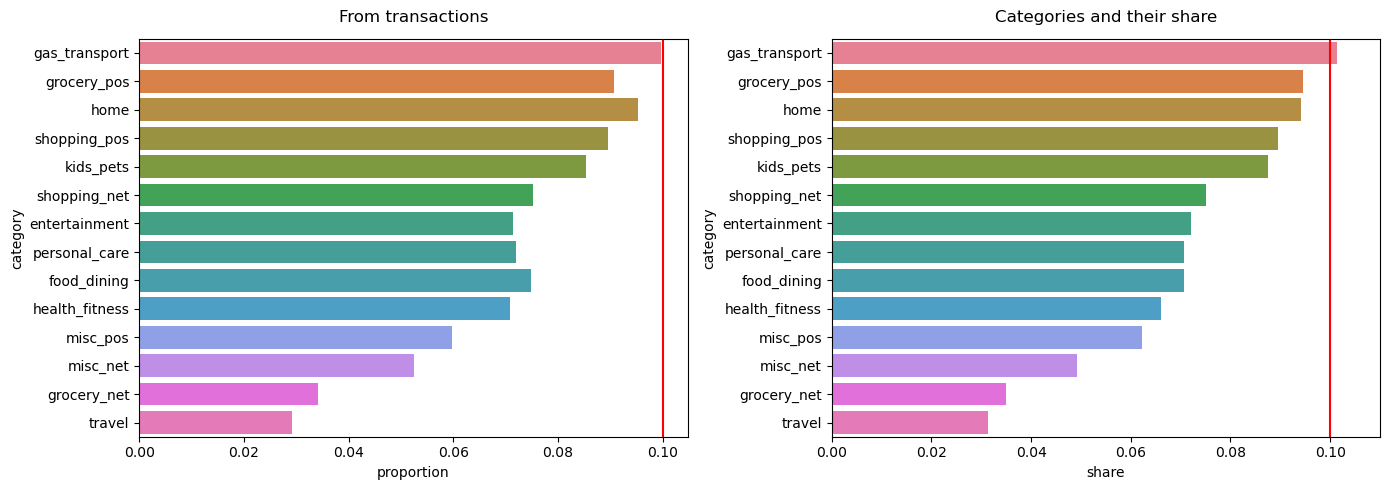

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

sns.barplot(data=cat_props_merged, x="proportion", y="category", hue="category", ax=ax[0])
ax[0].axvline(x=0.1, color="red")
ax[0].set_title("From transactions", pad=12)
sns.barplot(data=cat_props_merged, x="share", y="category", hue="category", ax=ax[1])
ax[1].axvline(x=0.1, color="red")
ax[1].set_title("Categories and their share", pad=12)
ax[1].set_xlim(0, 0.11)
plt.tight_layout();

In [105]:
# Проверка многократным семплированием категорий с переданными весами. 
# Для проверки того что все работает как надо при семплировании

cat_sample_150 = cat_stats_full.category.sample(6000, weights=cat_stats_full.share, replace=True) \
                                .value_counts(normalize=True).reset_index().merge(cat_stats_full, how="left", on="category") \
                                .sort_values("share", ascending=False)

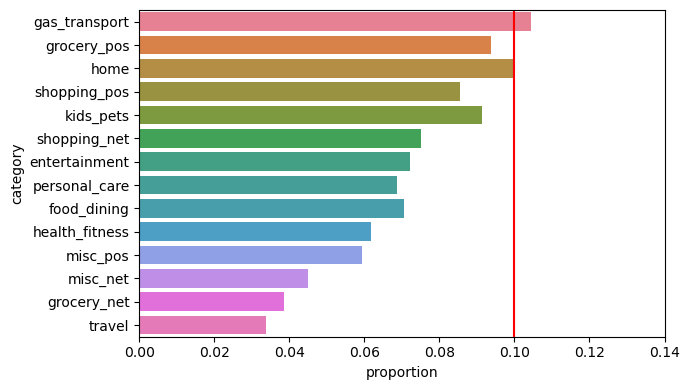

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

sns.barplot(data=cat_sample_150, x="proportion", y="category", hue="category", ax=ax)
ax.axvline(x=0.1, color="red")
ax.set_xlim(0, 0.14)
plt.tight_layout();

**Проверка распределения времени по категориям**

In [34]:
multi_legit_trans_test.head(2)

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,...,trans_ip,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m
0,4145,2025-01-01 02:51:00,1735699860,600.0,purchase,ecom,grocery_net,True,6974.0,Оренбург,...,2.60.15.82,7126.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN
1,2059,2025-01-01 03:03:00,1735700580,1.0,purchase,ecom,misc_net,True,6888.0,Иваново,...,2.60.7.153,3522.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN


In [35]:
cat_stats_full.head()

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
0,gas_transport,953.655019,237.425981,56370,False,0.101436,154,0.002732,True
1,grocery_pos,1738.279905,773.284951,52553,False,0.094568,485,0.009229,True
2,home,869.931194,721.279215,52345,False,0.094193,67,0.001280,False
3,shopping_pos,1152.936859,3487.270165,49791,False,0.089597,213,0.004278,False
4,kids_pets,862.603690,731.227232,48692,False,0.087620,65,0.001335,False


In [36]:
# джоин флага round clock к транзакциям. для разделения на сабсеты: оффлайн 24 часа, онлайн, оффлайн день

multi_legit_and_cats = multi_legit_trans_test.merge(cat_stats_full[["category", "round_clock"]].copy(), on="category")
multi_legit_and_cats.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,...,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,round_clock
0,4145,2025-01-01 02:51:00,1735699860,600.00,purchase,ecom,grocery_net,True,6974.0,Оренбург,...,7126.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
1,2059,2025-01-01 03:03:00,1735700580,1.00,purchase,ecom,misc_net,True,6888.0,Иваново,...,3522.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
2,1237,2025-01-01 05:20:00,1735708800,1.00,purchase,ecom,shopping_net,True,6850.0,Калуга,...,2152.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
3,3817,2025-01-01 06:23:00,1735712580,806.83,purchase,POS,gas_transport,False,3198.0,Волжский,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
4,2388,2025-01-01 06:57:00,1735714620,600.00,purchase,POS,food_dining,False,3751.0,Астрахань,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True


In [37]:
multi_legit_offline_24 = multi_legit_and_cats.query("online == False and round_clock == True")
multi_legit_offline_24.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,...,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,round_clock
3,3817,2025-01-01 06:23:00,1735712580,806.83,purchase,POS,gas_transport,False,3198.0,Волжский,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
4,2388,2025-01-01 06:57:00,1735714620,600.00,purchase,POS,food_dining,False,3751.0,Астрахань,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
5,10351,2025-01-01 07:13:00,1735715580,1352.54,purchase,POS,food_dining,False,4786.0,Архангельск,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
7,2226,2025-01-01 07:17:00,1735715820,1067.06,purchase,POS,gas_transport,False,864.0,Санкт-Петербург,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
8,3534,2025-01-01 07:21:00,1735716060,2458.90,purchase,POS,misc_pos,False,3629.0,Владивосток,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True


In [38]:
multi_legit_online = multi_legit_and_cats.query("online == True")
multi_legit_online.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,...,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,round_clock
0,4145,2025-01-01 02:51:00,1735699860,600.00,purchase,ecom,grocery_net,True,6974.0,Оренбург,...,7126.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
1,2059,2025-01-01 03:03:00,1735700580,1.00,purchase,ecom,misc_net,True,6888.0,Иваново,...,3522.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
2,1237,2025-01-01 05:20:00,1735708800,1.00,purchase,ecom,shopping_net,True,6850.0,Калуга,...,2152.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
6,1143,2025-01-01 07:13:00,1735715580,5821.48,purchase,ecom,shopping_net,True,6957.0,Краснодар,...,1995.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True
10,1983,2025-01-01 07:52:00,1735717920,1.00,purchase,ecom,misc_net,True,6826.0,Тула,...,3394.0,NaN,False,False,approved,not applicable,NaN,NaN,NaN,True


In [39]:
multi_legit_offline_day = multi_legit_and_cats.query("online == False and round_clock == False")
multi_legit_offline_day.head()

,client_id,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,...,device_id,account,is_fraud,is_suspicious,status,rule,prev_txn_unix,prev_online,prev_time_diff_m,round_clock
14,4544,2025-01-01 08:05:00,1735718700,808.45,purchase,POS,entertainment,False,5181.0,Челябинск,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,False
16,4482,2025-01-01 08:19:00,1735719540,1239.04,purchase,POS,shopping_pos,False,6448.0,Симферополь,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,False
20,278,2025-01-01 09:02:00,1735722120,1.00,purchase,POS,personal_care,False,2327.0,Чита,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,False
21,3483,2025-01-01 09:35:00,1735724100,662.24,purchase,POS,home,False,5957.0,Новосибирск,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,False
25,2744,2025-01-01 10:06:00,1735725960,3403.83,purchase,POS,shopping_pos,False,1927.0,Владивосток,...,NaN,NaN,False,False,approved,not applicable,NaN,NaN,NaN,False


In [40]:
# Проверка есть ли транзакции из дневной категории выходящие за установленные пределы по времени
# для этой категории - 08:00-21:59

assert multi_legit_offline_day.loc[(multi_legit_offline_day.txn_time.dt.hour < 8) | (multi_legit_offline_day.txn_time.dt.hour > 21)].empty

**Визуализация того, как распределено время транзакций по часам согласно их типу:**<br>
- оффлайн 24 часа, онлайн, дневной оффлайн

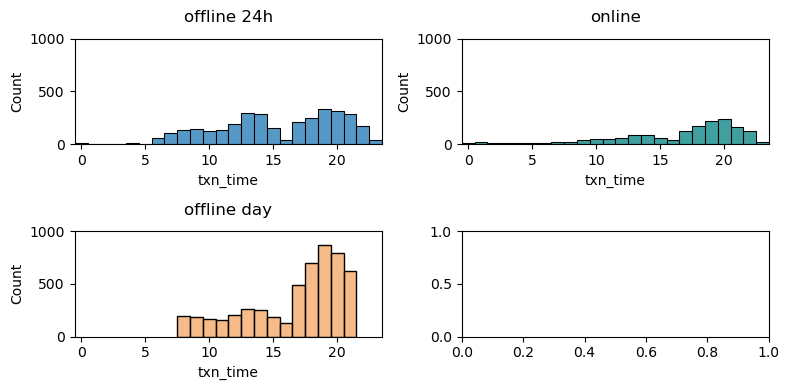

In [41]:
# при необходимости настроить ax.set_ylim() чтобы столбцы помещались в высоту 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,4))
titles = [["offline 24h", "online"], ["offline day"]]

sns.histplot(x=multi_legit_offline_24.txn_time.dt.hour, binwidth=1, discrete=True, ax=axes[0,0])
sns.histplot(x=multi_legit_online.txn_time.dt.hour, binwidth=1, discrete=True, color="teal", ax=axes[0,1])
p = sns.histplot(x=multi_legit_offline_day.txn_time.dt.hour, binwidth=1, discrete=True, color="sandybrown", ax=axes[1,0])

for row, title_pair in zip(axes, titles):
    for ax, title in zip(row, title_pair):
        ax.set_xlim(-0.5, 23.5)
        ax.set_ylim(0, 1000)
        ax.set_title(title, pad=12)
plt.tight_layout()
plt.show()

**Проверка средних сумм транзакций и стандартного отклонения сумм по категориям**

In [42]:
multi_legit_amt_avg_std = multi_legit_trans_test.groupby("category", as_index=False).agg({"amount":["mean","std"]})
multi_legit_amt_avg_std.columns = ["category", "avg_amt_real", "amt_std_real"]
multi_leg_amt_check_merged = multi_legit_amt_avg_std.merge(cat_stats_full[["category", "avg_amt", "amt_std"]], on="category")
multi_leg_amt_check_perc = pd.DataFrame(index=multi_legit_amt_avg_std.index, columns=["category", "avg_change","std_change"])

# Посчитаем на сколько процентов отличаются фактические среднее и стандартное отклонение от образца
multi_leg_amt_check_perc["category"] = multi_legit_amt_avg_std["category"]
multi_leg_amt_check_perc["avg_change"] = multi_leg_amt_check_merged.avg_amt_real.div(multi_leg_amt_check_merged.avg_amt).mul(100).sub(100)
multi_leg_amt_check_perc["std_change"] = multi_leg_amt_check_merged.amt_std_real.div(multi_leg_amt_check_merged.amt_std).mul(100).sub(100)

# Трансформация данных в длинный формат для построения двух графиков в seaborn
multi_leg_amt_check_perc_melt = multi_leg_amt_check_perc.melt(id_vars=["category"], value_vars=["avg_change", "std_change"], \
                                                        value_name="value", var_name="measure")
multi_leg_amt_check_perc_melt.iloc[np.r_[0:3,-3:0]]

,category,measure,value
0,entertainment,avg_change,2.112163
1,food_dining,avg_change,1.452707
2,gas_transport,avg_change,-1.508205
25,shopping_net,std_change,-29.248596
26,shopping_pos,std_change,-28.695482
27,travel,std_change,-36.024916


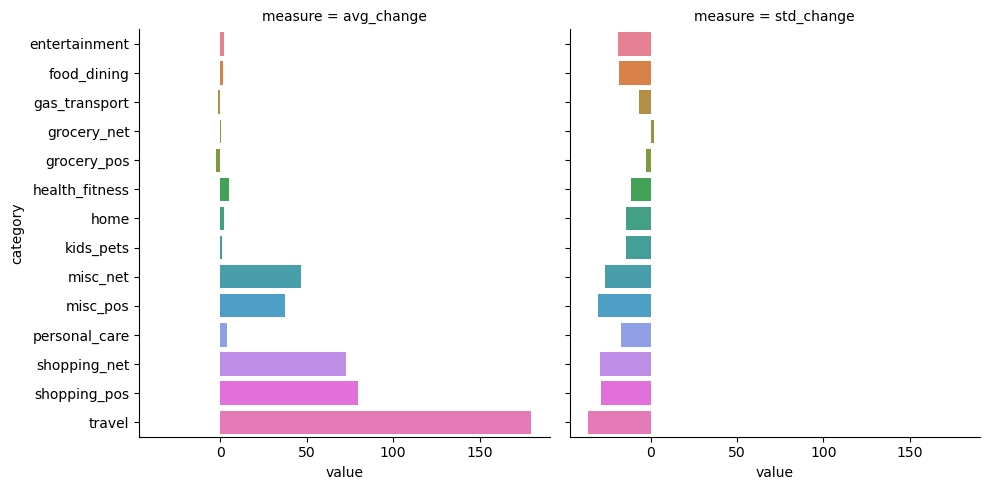

In [43]:
sns.catplot(x="value", y="category", col="measure", hue="category", kind="bar", data=multi_leg_amt_check_perc_melt);

Видимо у категорий у которых большое std, у тех и среднее сильнее отклоняется - имеется в виду график выше.  
Ниже график сравнения отклонений фактического среднего от среднего которое бралось для генерации и  
распределение стандартных отклонений которые использовались при генерации.  
Чтобы посмотреть зависимость  
Сортировка обоих датафреймов по категориям, чтобы было визуальное соответсвие

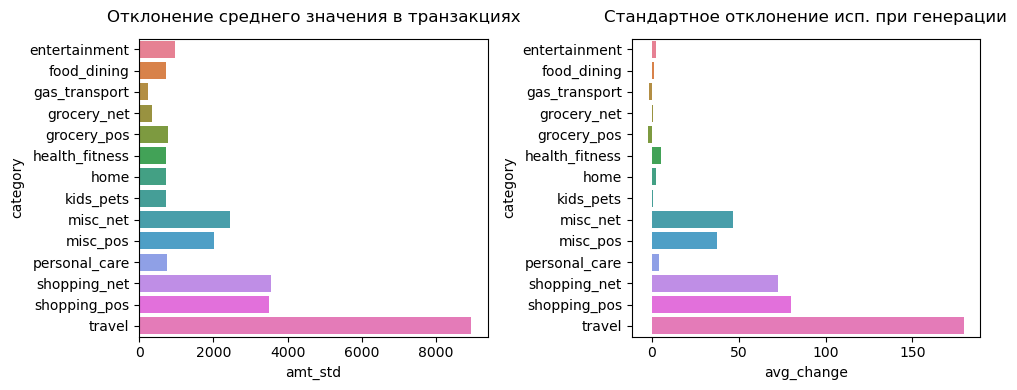

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.barplot(data=cat_stats_full[["category","amt_std"]].sort_values("category"), x="amt_std", y="category", \
                                                        hue="category", ax=ax[0])
sns.barplot(data=multi_leg_amt_check_perc.sort_values("category"), x="avg_change", y="category", hue="category", ax=ax[1])

ax[0].set_title("Отклонение среднего значения в транзакциях", pad=12)
ax[1].set_title("Стандартное отклонение исп. при генерации", pad=12)
plt.tight_layout();

**Проверка что города мерчантов совпадают с городами клиентов т.к. это легальные транзакции**

In [45]:
assert multi_legit_trans_test.merge(offline_merchants, on="merchant_id") \
                    .query("trans_city != city").empty

**Проверка что id онлайн мерчантов это id только от онлайн мерчантов, без оффлайн**

In [46]:
# Фильтрация по online и инверсия фильтрации по online_merchant_ids
# Если датафрейм на выходе пустой, то нет онлайн транзакций где id мерчанта взят из оффлайн

assert multi_legit_trans_test[(multi_legit_trans_test.online == True) \
        & ~(multi_legit_trans_test.merchant_id.isin(online_merchant_ids))].empty

In [47]:
# такая же проверка для оффлайн мерчантов

assert multi_legit_trans_test[(multi_legit_trans_test.online == False) \
       & ~(multi_legit_trans_test.merchant_id.isin(offline_merchants.merchant_id))].empty

**Проверка на пустые значения**

In [48]:
# проверка на пустые значения в целом

multi_legit_trans_test.isna().sum()

client_id               0
txn_time                0
unix_time               0
amount                  0
type                    0
channel                 0
category                0
online                  0
merchant_id             0
trans_city              0
trans_lat               0
trans_lon               0
trans_ip                0
device_id            8522
account             10167
is_fraud                0
is_suspicious           0
status                  0
rule                    0
prev_txn_unix         200
prev_online           200
prev_time_diff_m      200
dtype: int64

In [49]:
# проверка на пустые значения для онлайн транзакций
# не должно быть пустых device_id

multi_legit_online_only = multi_legit_trans_test.query("online == True")
multi_legit_online_only.device_id.isna().any()

np.False_

In [50]:
# Есть ли онлайн транзакции где нет IP адреса

assert multi_legit_online_only.query("trans_ip == 'not applicable'").empty

**Проверка правильности генерации девайсов клиентов**

In [51]:
# Джоин таблицы с девайсами к таблице транзакций по device_id

multi_legit_devices = multi_legit_online_only.merge(client_devices, on="device_id").copy() \
                                            .drop(columns=['account', 'is_fraud', 'is_suspicious', 'status', \
                                                           'rule', 'prev_txn_unix', 'prev_online', 'prev_time_diff_m'])
multi_legit_devices.head()

,client_id_x,txn_time,unix_time,amount,type,channel,category,online,merchant_id,trans_city,trans_lat,trans_lon,trans_ip,device_id,client_id_y,platform
0,4145,2025-01-01 02:51:00,1735699860,600.00,purchase,ecom,grocery_net,True,6974.0,Оренбург,51.787519,55.101738,2.60.15.82,7126.0,4145,Android
1,2059,2025-01-01 03:03:00,1735700580,1.00,purchase,ecom,misc_net,True,6888.0,Иваново,56.999468,40.972823,2.60.7.153,3522.0,2059,Android
2,1237,2025-01-01 05:20:00,1735708800,1.00,purchase,ecom,shopping_net,True,6850.0,Калуга,54.506044,36.251593,2.60.4.153,2152.0,1237,Android
3,1143,2025-01-01 07:13:00,1735715580,5821.48,purchase,ecom,shopping_net,True,6957.0,Краснодар,45.040235,38.976080,2.60.4.65,1995.0,1143,Android
4,1983,2025-01-01 07:52:00,1735717920,1.00,purchase,ecom,misc_net,True,6826.0,Тула,54.192017,37.615389,2.60.7.81,3394.0,1983,Android


In [52]:
# Проверка где device_id взят от другого клиента

assert multi_legit_devices.query("client_id_x != client_id_y").empty

**Распределение платформ в транзакциях**

In [53]:
# Распределение в транзакциях

multi_legit_platforms = multi_legit_devices.platform.value_counts(normalize=True).reset_index()
multi_legit_platforms

,platform,proportion
0,Android,0.480243
1,Windows,0.299088
2,macOS,0.103951
3,iOS,0.083891
4,Linux,0.032827


In [54]:
# Распределение у клиентов

client_platforms_share = client_devices.platform.value_counts(normalize=True).reset_index()
client_platforms_share

,platform,proportion
0,Android,0.448240
1,Windows,0.320848
2,macOS,0.106606
3,iOS,0.077897
4,Linux,0.046409


In [55]:
# Сверка

multi_legit_platforms.merge(client_platforms_share, on="platform", suffixes = ("_fact","_src"))

,platform,proportion_fact,proportion_src
0,Android,0.480243,0.448240
1,Windows,0.299088,0.320848
2,macOS,0.103951,0.106606
3,iOS,0.083891,0.077897
4,Linux,0.032827,0.046409


**Сверка корректности IP адресов**

In [56]:
clients.head()

,client_id,city_id,birth_date,sex,region,city,timezone,lat,lon,population,home_ip
0,1,18,1995-12-07,female,Рязанская,Рязань,UTC+3,54.625457,39.735999,525062,2.60.0.1
1,2,1,1970-01-29,male,Москва,Москва,UTC+3,55.753879,37.620373,11514330,2.60.0.2
2,3,1,1965-10-03,female,Москва,Москва,UTC+3,55.753879,37.620373,11514330,2.60.0.3
3,4,5,1981-11-25,male,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,2.60.0.4
4,5,5,1985-06-27,female,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,2.60.0.5


In [57]:
# Джоин по IP адресам. И проверка есть ли несоответсвие client_id - не получил ли клиент чужой IP для транзакции

assert multi_legit_online_only.merge(clients, left_on="trans_ip", right_on="home_ip") \
                        .query("client_id_x != client_id_y").empty

### **Конец теста `gen_multiple_legit_txns`**

# **Конец информативной части**

# Генерация транзакций частями и запись в `parquet` - **старое**

In [59]:
# # Берем значения индексов для каждого квантиля

# clients_index_chunks = clients_sample.index.copy().to_series().quantile(quantile_bounds).reset_index() \
#                                         .rename(columns={0:"lower_bound"}).drop(columns="index")

In [60]:
# # в колонке upper_bound верхняя граница чанка. Но надо отнять 1 от верхней границы, 
# # кроме последнего чанка, чтобы не было дублирования. Также округляем нецелые числа в меньшую сторону в обоих колонках
# clients_index_chunks["upper_bound"] = clients_index_chunks["lower_bound"].shift(-1).sub(1).apply(np.floor)
# # делаем значение верхней границы последнего чанка прежним
# clients_index_chunks.loc[5, "upper_bound"] += 1 
# clients_index_chunks["lower_bound"] = clients_index_chunks["lower_bound"].apply(np.floor)
# clients_index_chunks = clients_index_chunks.drop(index=6).astype({"lower_bound":"int", "upper_bound":"int"})
# clients_index_chunks

**Проверка что не теряем клиентов и нет ошибок при разделении на намеченные чанки**

In [17]:
# client_chunks_test = defaultdict(pd.DataFrame)

In [18]:
# # Запишем чанки в словарь

# for row in clients_index_chunks.itertuples():
#     chunk_num = row.Index + 1
#     client_chunks_test[f"chunk_{chunk_num:04d}"] = clients.loc[row.lower_bound:row.upper_bound]

In [61]:
# # Соберем чанки обратно в единый датафрейм. Проверим размеры чанков и итогового датафрейма

# total_length = 0
# clients_fm_chunks = [pd.DataFrame(columns=clients.columns)]

# for chunk in client_chunks_test.values():
#     print(chunk.shape)
#     total_length += chunk.shape[0]
#     clients_fm_chunks.append(chunk)

# print(total_length)
# clients_fm_chunks = pd.concat(clients_fm_chunks, ignore_index=True)
# clients_fm_chunks.head()

**Генерация чанков и запись в файлы**

In [58]:
# %%time
# for row in clients_index_chunks.itertuples():
#     clients_subset = clients_sample_df.loc[row.lower_bound:row.upper_bound]
#     trans_df = transactions.copy()
#     chunk_num = row.Index + 1
    
#     chunk = gen_multiple_legit_trans(clients_df=clients_subset, trans_df=trans_df, client_devices=client_devices, \
#                                                   offline_merchants=offline_merchants, timestamps=timestamps, \
#                                                   timestamps_1st_month=timestamps_1st_month, \
#                                                  categories=cat_stats_full,  online_merchant_ids=online_merchant_ids, \
#                                                   time_weights_dict=time_weights_dict)

#     print(f"Chunk #{chunk_num}")
#     # Запись чанка в файл с название по типу legit_000.parquet
#     chunk.to_parquet(f"./data/generated_data/legit_{chunk_num:03d}.parquet", engine="pyarrow")

In [735]:
# import cProfile

In [736]:
# clients_100 = clients_with_geo[:100].copy()

In [737]:
# trans_for_profile = transactions.copy()

In [734]:
# cProfile.run("""gen_multiple_legit_trans(clients_df=clients_100, trans_df=trans_for_profile, client_devices=client_devices, \
#                                                   offline_merchants=offline_merchants, timestamps=timestamps, \
#                                                   timestamps_1st_month=timestamps_1st_month, \
#                                                  categories=cat_stats_full,  online_merchant_ids=online_merchant_ids, \
#                                                   time_weights_dict=time_weights_dict)""")

         62479729 function calls (61327738 primitive calls) in 71.822 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4985    0.012    0.000    0.012    0.000 1028514059.py:1(build_transaction)
      173    0.009    0.000    0.009    0.000 1323426738.py:1(pd_timestamp_to_unix)
        1    0.353    0.353   71.818   71.818 1480622854.py:1(gen_multiple_legit_trans)
     4985    0.128    0.000   40.047    0.008 2313945978.py:1(get_time_for_trans)
      100    0.003    0.000    0.199    0.002 2911961910.py:1(sample_time_for_trans)
      100    0.001    0.000    0.049    0.000 3202737387.py:1(gen_trans_number_norm)
     4985    0.098    0.000    6.663    0.001 331495167.py:1(get_txn_location_and_merchant)
     4885    0.308    0.000   29.181    0.006 3362071607.py:1(check_min_interval_from_near_trans)
     4885    0.237    0.000   29.419    0.006 3511359992.py:1(handle_legit_case_time)
     4985    0.277    0.000   49.316  